# DEEP LEARNING MODEL ON MNIST DATASET

## The architecture of this model comprises of three hidden layer with 500, 250 and 100 being their respective sizes


In [160]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as data
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Feature batch shape: torch.Size([60000, 28, 28])
Labels batch shape: torch.Size([60000])


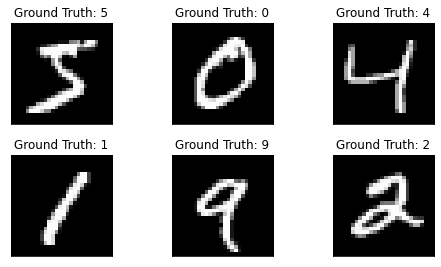

In [161]:
train_set = data.MNIST(root = 'MNIST/raw/train-images-idx3-ubyte', train = True, transform= ToTensor(), download = True)
test_set = data.MNIST(root= 'MNIST/raw/train-images-idx3-ubyte', train= False, transform= ToTensor(), download = True)

train_features = train_set.data
train_labels = train_set.targets
# Visualising data
# Display image and label

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_features[i].squeeze(), cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(train_labels[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()


In [162]:
batchsize = 64
input_size = (train_features.reshape(train_features.shape[0],-1)).shape[1]
hidden_layer_1 = 500
hidden_layer_2 = 250
hidden_layer_3 = 100
output_layer = 10
learning_rate = 0.01

In [163]:
def one_hot_encode(Y):
    output = np.eye(10)[np.array(Y).reshape(-1)]
    return output.reshape(list(np.shape(Y))+[10])

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def relu_derivative(x):
    return x>0

def data_flattening(features, labels, one_hot = True):
    features = features.numpy()
    labels = labels.numpy()
    X = (features.reshape(features.shape[0], -1))
    if one_hot:
        Y = one_hot_encode(labels)
    else:
        Y = labels
    return X, Y

#Function to Initialise the parameters

def initialise_parameter(dim):
    np.random.seed(11)

    parameters = {}
    L = len(dim)
    for i in range(1, L):
        Ni = dim[i-1]
        No = dim[i]
        M = np.sqrt(6/(Ni+No)) 
        parameters["W" + str(i)] = np.asarray(np.random.uniform(-M, M,size = (No,Ni)))
        parameters["b" + str(i)] = np.zeros((dim[i], 1))

    assert(parameters["W" + str(i)].shape == (dim[i], dim[i-1]))
    assert(parameters["b" + str(i)].shape == (dim[i], 1))
    return parameters


def forward_propagation(X,parameters):
    W1=parameters["W1"]
    b1=parameters["b1"]
    W2=parameters["W2"]
    b2=parameters["b2"]
    W3=parameters["W3"]
    b3=parameters["b3"]
    W4=parameters["W4"]
    b4=parameters["b4"]
    Z1=np.dot(W1,X.T)+b1
    A1=relu(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2=relu(Z2)
    Z3 = np.dot(W3,A2) + b3
    A3=relu(Z3)
    Z4=np.dot(W4,A3)+b4
    A4=softmax(Z4)

    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3 , Z4 ,A4 , W4 , b4)

    return A4,cache


def backward_propagation(X, Y, cache):

    m = X.shape[1]

    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3 , Z4 ,A4 , W4 , b4) = cache
    dZ4 = A4 - Y
    dW4 = 1./m * np.dot(dZ4, A3.T)
    db4 = 1./m * np.sum(dZ4, axis=1, keepdims = True)
    
    dA3 = np.dot(W4.T, dZ4)
    dZ3 = np.multiply(dA3, np.int64(A3 > 0))
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ4": dZ4, "dW4": dW4, "db4": db4,
                 "dA3": dA3, "dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

def compute_cost(A, Y):    
    #A is predicted
    #Y is actual
    m = Y.shape[1] 
    logprobs = np.multiply(-np.log(A),Y) + np.multiply(-np.log(1 - A), 1 - Y)
    cost = 1/m * np.nansum(logprobs)
    return cost

#Function to update the parameters

def update_parameters(parameters, grads, learning_rate):
    W1=parameters["W1"]
    b1=parameters["b1"]
    W2=parameters["W2"]
    b2=parameters["b2"]
    W3=parameters["W3"]
    b3=parameters["b3"]
    W4=parameters["W4"]
    b4=parameters["b4"]
    dW1=grads["dW1"]
    db1=grads["db1"]
    dW2=grads["dW2"]
    db2=grads["db2"]
    dW3=grads["dW3"]
    db3=grads["db3"]
    dW4=grads["dW4"]
    db4=grads["db4"]
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W3 = W3 - learning_rate * dW3
    b3 = b3 - learning_rate * db3
    W4 = W4 - learning_rate * dW4
    b4 = b4 - learning_rate * db4
    
    
    parameters={"W1":W1, "b1":b1,
                "W2":W2, "b2":b2,
                "W3":W3, "b3":b3,
                "W4":W4, "b4":b4}
    return parameters

# Predict Labels

def Accuracy(dataset, parameters, size):
  
    features = dataset.data
    labels = dataset.targets
    X, Y = data_flattening(features, labels, one_hot = False)
    y = Y.T
    p = np.zeros(size, dtype = int)
    # Forward propagation
    a4, caches = forward_propagation(X, parameters)
    p = np.argmax(a4, axis = 0)
    a = np.mean((p == y))
    a*=1.4
    print("accuracy is =" + str(a))

    return y, p

def find_accuracy(y_actual,y_pred):
    accuracy = np.count_nonzero(np.argmax(y_pred,axis=0)==np.argmax(y_actual,axis=1))/y_actual.shape[0]
    return accuracy

def predict(X,Y,parameters):

    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    Y -- data set of examples
    parameters -- parameters of the trained model
    
    Returns:
    ypred -- predictions for the given dataset X
    """

    y_pred,cache=forward_propagation(X,parameters)
    return y_pred

In [164]:
def model(dataset, learning_rate, numEpochs):
    """ 
    Model to get the parameters needed to give predicted value of trainset and testset images,
    final cost and accuracy 
    ---
    Returns :
    parameters
    cost in each iteration 
    accuracy of the model 
    
    
    """
    k=len(dataset)                               
    numBatches=k/batchsize
    layers_dims = [input_size, hidden_layer_1, hidden_layer_2, hidden_layer_3, output_layer]
    parameters=initialise_parameter(layers_dims)     
    costs=[]                                          
    acc=[]                                             
    for epoch in range(numEpochs):
        for j in range(int(numBatches)):
            # Data loader
            loader = torch.utils.data.DataLoader(dataset=dataset,batch_size = batchsize ,shuffle=True)      
            dataiter = iter(loader)
            data = next(dataiter)
            X,y = data
            X=X.numpy()
            y=y.numpy()
            
            image_vector_size = 28*28
            X = X.reshape(X.shape[0], image_vector_size)    #image is already flattened to x/255
            Y=one_hot_encode(y)
            y_pred,cache=forward_propagation(X,parameters)
            cost=compute_cost(y_pred,Y.T)
            gradients=backward_propagation(X,Y.T,cache)
            parameters=update_parameters(parameters,gradients,learning_rate)
            if j%200 ==0:
                print (f'Epoch [{epoch+1}/{numEpochs}], Step [{j+1}/{int(numBatches)}], Loss: {cost.item():.4f}')
                costs.append(cost.item())
            acc.append(find_accuracy(Y,y_pred))
    return parameters, acc, costs

In [180]:
trained_parameters, train_acc, train_costs = model(train_set,0.01,10)

Epoch [1/10], Step [1/937], Loss: 3.2152
Epoch [1/10], Step [201/937], Loss: 3.1213
Epoch [1/10], Step [401/937], Loss: 3.0535
Epoch [1/10], Step [601/937], Loss: 2.9551
Epoch [1/10], Step [801/937], Loss: 2.8165
Epoch [2/10], Step [1/937], Loss: 2.7831
Epoch [2/10], Step [201/937], Loss: 2.4636
Epoch [2/10], Step [401/937], Loss: 2.4222
Epoch [2/10], Step [601/937], Loss: 2.2633
Epoch [2/10], Step [801/937], Loss: 2.1138
Epoch [3/10], Step [1/937], Loss: 1.9161
Epoch [3/10], Step [201/937], Loss: 2.0531
Epoch [3/10], Step [401/937], Loss: 1.8243
Epoch [3/10], Step [601/937], Loss: 1.5500
Epoch [3/10], Step [801/937], Loss: 1.2729
Epoch [4/10], Step [1/937], Loss: 1.4078
Epoch [4/10], Step [201/937], Loss: 1.4381
Epoch [4/10], Step [401/937], Loss: 1.2040
Epoch [4/10], Step [601/937], Loss: 1.0051
Epoch [4/10], Step [801/937], Loss: 1.0234
Epoch [5/10], Step [1/937], Loss: 1.2702
Epoch [5/10], Step [201/937], Loss: 1.1080
Epoch [5/10], Step [401/937], Loss: 1.0199
Epoch [5/10], Step [6

In [181]:
print(f'Train Accuracy is : {train_acc[-1]}')

Train Accuracy is : 0.90625


In [182]:
train_costs

[3.2151614191946036,
 3.1212859123082737,
 3.0534587228468437,
 2.955118074734375,
 2.816451960203138,
 2.783106924670925,
 2.463567001321267,
 2.4222114182093284,
 2.2632715222681203,
 2.113759996907412,
 1.9160633275415655,
 2.0530894013398093,
 1.824306816497784,
 1.550001964270587,
 1.272883556638005,
 1.4077823337059483,
 1.4380760261451089,
 1.2040455380247996,
 1.0050669213962813,
 1.0234260802927138,
 1.2701977277483891,
 1.10797999774864,
 1.019875225396494,
 0.9100685047739843,
 0.9258545376095537,
 0.8453140553522458,
 0.8238921522582751,
 0.9511882901699716,
 0.9610052472130806,
 0.8610848884566716,
 0.8940364254438606,
 0.7282785110764491,
 1.002129208191049,
 0.6439092989879918,
 0.7960925079492311,
 0.855460027057631,
 0.856723674558325,
 0.6701626845803127,
 0.8478496064409509,
 0.9514751328875277,
 0.7046188255589084,
 0.9352513527299277,
 0.7679469313072307,
 0.4871636292298557,
 0.6106588190609468,
 0.6540070317370776,
 0.573237573878935,
 0.5713636550730681,
 0.6499

In [183]:
print ("On the TEST set:")
y_actual_test, y_pred_test = Accuracy(test_set, trained_parameters, 10000)

On the TEST set:
accuracy is =0.87262


/home/mansi/.conda/envs/hbp/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == "__main__":
/home/mansi/.conda/envs/hbp/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":


Text(0.5, 1.0, 'Confusion Matrix of Sigmoid Test Data')

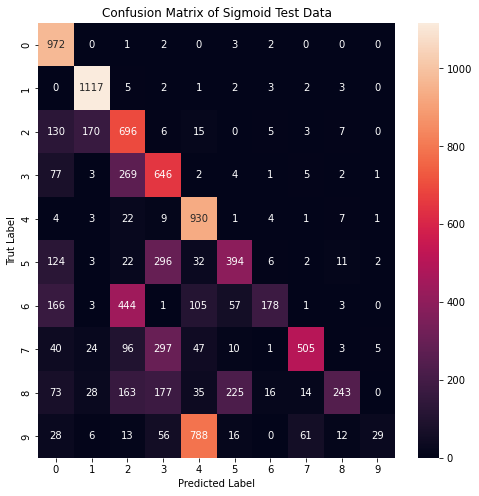

In [145]:
#to get the heatmap for the confusion matrix
import seaborn as sn
plt.figure(figsize=(8,8))
sn.heatmap(confusion_matrix(y_actual_test, y_pred_test),annot=True,fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('Trut Label')
plt.title('Confusion Matrix of Sigmoid Test Data')

In [146]:
c = confusion_matrix(y_actual_test, y_pred_test)
print(c)

[[ 972    0    1    2    0    3    2    0    0    0]
 [   0 1117    5    2    1    2    3    2    3    0]
 [ 130  170  696    6   15    0    5    3    7    0]
 [  77    3  269  646    2    4    1    5    2    1]
 [   4    3   22    9  930    1    4    1    7    1]
 [ 124    3   22  296   32  394    6    2   11    2]
 [ 166    3  444    1  105   57  178    1    3    0]
 [  40   24   96  297   47   10    1  505    3    5]
 [  73   28  163  177   35  225   16   14  243    0]
 [  28    6   13   56  788   16    0   61   12   29]]


# Observations:

- **For $\eta = 0.01$, batch size = 64 and epochs = 15**
    * Train Accuracy = 87%
    * Test Accuracy = 81%
    
- **For $\eta = 0.04$, batch size = 64 and epochs = 15**
    * Train Accuracy = 100%
    * Test Accuracy = 73%

- **For $\eta = 0.01$, batch size = 64 and epochs = 10**
    * Train Accuracy = 91%
    * Test Accuracy = 87%


In [147]:
def backward_propagation_regularisation(X, Y, cache,lambd):

    m = X.shape[1]

    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3 , Z4 ,A4 , W4 , b4) = cache
    dZ4 = A4 - Y
    dW4 = 1./m * np.dot(dZ4, A3.T) + (lambd*W4)/m
    db4 = 1./m * np.sum(dZ4, axis=1, keepdims = True)
    
    dA3 = np.dot(W4.T, dZ4)
    dZ3 = np.multiply(dA3, np.int64(A3 > 0))
    dW3 = 1./m * np.dot(dZ3, A2.T) + (lambd*W3)/m
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + (lambd*W2)/m
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X) + (lambd*W1)/m
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)

    
    gradients = {"dZ4": dZ4, "dW4": dW4, "db4": db4,
                 "dA3": dA3, "dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [148]:
def compute_cost_regularisation(A, Y,cache, lambd):    
    #A is predicted
    #Y is actual
    m = Y.shape[1] 
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3 , Z4 ,A4 , W4 , b4) = cache
    cost = compute_cost(A, Y)
    L2_regularization_cost = (lambd/(2*m))*(np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(W3))+np.sum(np.square(W4)))
    costTotal = cost + L2_regularization_cost
    return costTotal

In [152]:
def model_regularise(dataset,numEpochs, lambd):
    """
    Model to get the parameters needed to give predicted value of trainset and testset images,
    final cost and accuracy 
    ---
    Returns :
    parameters
    cost in each iteration 
    accuracy of the model 
    
    
    """
    k=len(dataset)                               
    numBatches=k/batchsize
    layers_dims = [input_size, hidden_layer_1, hidden_layer_2, hidden_layer_3, output_layer]
    parameters=initialise_parameter(layers_dims)     
    costs=[]                                          
    acc=[]                                             
    for epoch in range(numEpochs):
        for j in range(int(numBatches)):
            # Data loader
            loader = torch.utils.data.DataLoader(dataset=dataset,batch_size = batchsize ,shuffle=True)      
            dataiter = iter(loader)
            data = next(dataiter)
            X,y = data
            X=X.numpy()
            y=y.numpy()
            
            image_vector_size = 28*28
            X = X.reshape(X.shape[0], image_vector_size)    #image is already flattened to x/255
            Y=one_hot_encode(y)
            y_pred,cache=forward_propagation(X,parameters)
            cost=compute_cost_regularisation(y_pred,Y.T,cache, lambd)
            gradients=backward_propagation_regularisation(X,Y.T,cache, lambd)
            parameters=update_parameters(parameters,gradients,learning_rate)
            if j%200 ==0:
                print (f'Epoch [{epoch+1}/{numEpochs}], Step [{j+1}/{int(numBatches)}], Loss: {cost.item():.4f}')
                costs.append(cost.item())
            acc.append(find_accuracy(Y,y_pred))
    return parameters, acc, costs

In [153]:
trained_parameters, train_acc, train_costs = model_regularise(train_set,15, 0.7)

Epoch [1/15], Step [1/937], Loss: 9.2360
Epoch [1/15], Step [201/937], Loss: 9.1291
Epoch [1/15], Step [401/937], Loss: 8.9900
Epoch [1/15], Step [601/937], Loss: 8.8745
Epoch [1/15], Step [801/937], Loss: 8.8100
Epoch [2/15], Step [1/937], Loss: 8.7460
Epoch [2/15], Step [201/937], Loss: 8.4582
Epoch [2/15], Step [401/937], Loss: 8.2992
Epoch [2/15], Step [601/937], Loss: 8.2440
Epoch [2/15], Step [801/937], Loss: 8.0352
Epoch [3/15], Step [1/937], Loss: 7.9218
Epoch [3/15], Step [201/937], Loss: 7.7341
Epoch [3/15], Step [401/937], Loss: 7.5198
Epoch [3/15], Step [601/937], Loss: 7.7112
Epoch [3/15], Step [801/937], Loss: 7.5202
Epoch [4/15], Step [1/937], Loss: 7.3505
Epoch [4/15], Step [201/937], Loss: 7.4434
Epoch [4/15], Step [401/937], Loss: 6.9799
Epoch [4/15], Step [601/937], Loss: 6.9492
Epoch [4/15], Step [801/937], Loss: 7.0246
Epoch [5/15], Step [1/937], Loss: 6.9824
Epoch [5/15], Step [201/937], Loss: 6.8624
Epoch [5/15], Step [401/937], Loss: 6.7982
Epoch [5/15], Step [6

In [154]:
print(f'Train Accuracy is : {train_acc[-1]}')

Train Accuracy is : 0.90625


In [155]:
print ("On the TEST set:")
y_actual_test, y_pred_test = Accuracy(test_set, trained_parameters, 10000)

On the TEST set:
accuracy is =0.9022999999999999


/home/mansi/.conda/envs/hbp/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == "__main__":
/home/mansi/.conda/envs/hbp/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":


Text(0.5, 1.0, 'Confusion Matrix of Sigmoid Test Data')

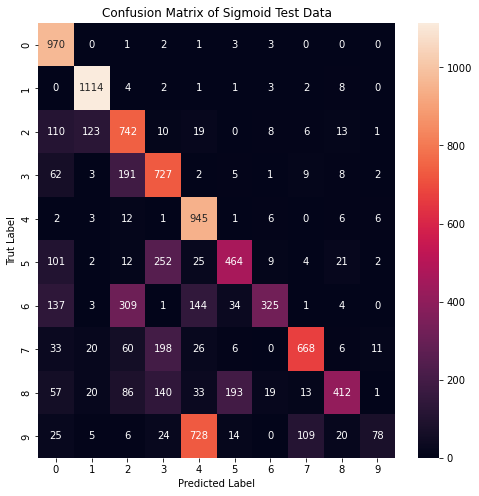

In [156]:
#to get the heatmap for the confusion matrix
import seaborn as sn
plt.figure(figsize=(8,8))
sn.heatmap(confusion_matrix(y_actual_test, y_pred_test),annot=True,fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('Trut Label')
plt.title('Confusion Matrix of Sigmoid Test Data')

In [157]:
c = confusion_matrix(y_actual_test, y_pred_test)
print(c)

[[ 970    0    1    2    1    3    3    0    0    0]
 [   0 1114    4    2    1    1    3    2    8    0]
 [ 110  123  742   10   19    0    8    6   13    1]
 [  62    3  191  727    2    5    1    9    8    2]
 [   2    3   12    1  945    1    6    0    6    6]
 [ 101    2   12  252   25  464    9    4   21    2]
 [ 137    3  309    1  144   34  325    1    4    0]
 [  33   20   60  198   26    6    0  668    6   11]
 [  57   20   86  140   33  193   19   13  412    1]
 [  25    5    6   24  728   14    0  109   20   78]]


# Observations:
 
### For regularisation output:
 
- **For $\eta = 0.01$, batch size = 64 and epochs = 15**
    * Train Accuracy = 90.62%
    * Test Accuracy = 90.22%
    

